# **Modelos base**

En este apartado, aplicaremos los ocho modelos de regresión estudiados en clase para determinar cuál de ellos es el más efectivo en la predicción de la velocidad del viento. La evaluación se llevará a cabo utilizando el valor de R², seleccionando el modelo con el mayor valor de esta métrica como el mejor para la predicción.

## **Librerías y módulos necesarios**

In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.svm import SVR
import statsmodels.api as sm
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from skopt.space import Integer, Categorical, Real
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from sklearn import neighbors
from sklearn.metrics import mean_squared_log_error
import numpy as np

## **Base de datos y métodos útiles**

In [2]:
data = pd.read_csv("C:/Users/valcd/OneDrive/Escritorio/dataparcial2.csv")
data

,hora,direccionviento,velocidadviento,humedadmaxima,humedadminima,temperaturamaxima,temperaturaminima,precipitaciontotal,rafagamaxima,presion_atm_maxima,presion_atm_minima
0,12:00,0.809017,1.8,69.0,60.0,22.6,20.7,0.0,3.8,888.2,887.7
1,13:00,0.965926,2.7,62.0,55.0,24.2,22.5,0.0,4.7,888.4,888.2
2,14:00,0.891007,2.0,56.0,50.0,25.5,24.3,0.0,4.9,888.4,888.1
3,15:00,0.848048,2.5,52.0,44.0,27.4,25.0,0.0,5.8,888.1,887.4
4,16:00,0.224951,2.4,50.0,43.0,27.1,25.5,0.0,5.8,887.4,886.5
...,...,...,...,...,...,...,...,...,...,...,...
87688,19:00,-0.615661,5.6,83.0,78.0,21.8,21.1,0.0,12.3,879.8,879.1
87689,20:00,-0.469472,4.9,84.0,79.0,21.7,21.0,0.0,9.9,879.2,878.9
87690,21:00,-0.484810,4.5,86.0,82.0,21.2,20.6,0.0,8.9,879.8,879.2
87691,22:00,-0.484810,3.2,88.0,85.0,20.6,20.2,0.0,8.0,880.5,879.6


In [3]:
X = data.drop(columns=['hora','velocidadviento']) # Se toman todas las columnas excepto la objetivo
y = data['velocidadviento'] # Se toma solo la columna objetivo

In [46]:
def errorporc(actual, predicho):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicho[j]) / actual[j]
        else:
            res[j] = predicho[j] / np.mean(actual)
    return res

def MAPE(y_true, y_pred): 
    return np.mean(np.abs(errorporc(np.asarray(y_true), np.asarray(y_pred))))*100

# Método para calcular los residuos del modelo

def residuos(y_test, y_prediccion):
    residuo = y_test - y_prediccion
    ljung = acorr_ljungbox(residuo, lags=[10], return_df=True)['lb_pvalue'].values[0]
    jarque = jarque_bera(residuo)  
    jarque = jarque[1]
    return ljung, jarque, residuo

## **MODELOS**

Antes de aplicar los modelos, es importante señalar que la partición de los conjuntos de datos se realizó respetando el orden temporal de las observaciones en nuestra base de datos. Dado que cada observación corresponde a una hora específica del día, y estas están organizadas en bloques de 24 (es decir, cada 24 observaciones representan un día completo), se debe mantener este orden para evitar problemas como predecir el pasado a partir de datos futuros. Como nuestro objetivo es predecir las 24 horas siguientes, la partición se hizo manualmente: las **últimas 24 observaciones** se asignaron al **conjunto de test**, las **24 anteriores** al **conjunto de validación**, y el **resto de los datos** (es decir, todos excepto las últimas 48 observaciones) se utilizaron como **conjunto de entrenamiento**.

In [5]:
n = len(X) 

test_size = 24
val_size = 24

X_test = X[-test_size:] 
y_test = y[-test_size:]

X_val = X[-(test_size + val_size):-test_size]  
y_val = y[-(test_size + val_size):-test_size]

X_train = X[:-(test_size + val_size)]  
y_train = y[:-(test_size + val_size)]

De forma general, el proceso para aplicar estos modelos consistió inicialmente en la búsqueda de los mejores hiperparámetros. Esto se llevó a cabo mediante un ciclo ***for*** que exploraba diversas combinaciones de opciones, calculando el valor de R² para cada una. Luego, se compararon los resultados obtenidos con un ***IF*** para identificar qué combinación de hiperparámetros generaba la mejor métrica, es decir, el valor más alto de R². Finalmente, se utilizaron esos mejores hiperparámetros para realizar las respectivas predicciones, empleando el mejor modelo en cada caso.

## **KNN**

Para este modelo, los hiperparámetros utilizados fueron:

* **`n_neighbors`** : número de vecinos más cercanos que se consideran para realizar la predicción.

* **`p`** : distancia utilizada en el modelo. 

    * **p = 1**, distancia Manhattan (suma de valores absolutos).
    * **p = 2**, distancia Euclidiana (distancia recta en un espacio).

In [6]:
r2_val = []
best_r2 = -float('inf')  
best_k = None
best_p = None

for p in [1, 2]:
    for k in range(1, 51):
        knn = neighbors.KNeighborsRegressor(n_neighbors=k, p=p)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_val)
        r2 = r2_score(y_val, y_pred)  
        
        if r2 > best_r2:  
            best_r2 = r2
            best_k = k
            best_p = p
        
        r2_val.append((k, p, r2))

print(f"Best R²: {best_r2}, Best k: {best_k}, Best p: {best_p}")


Best R²: 0.6123083160645104, Best k: 20, Best p: 1


Luego de entrenar el modelo con los datos de entrenamiento y realizar predicciones en el conjunto de validación, se evaluaron las combinaciones de hiperparámetros. La mejor de estas, que alcanzó el mayor valor de R² entre todos, fue `20 vecinos` y `p = 1`, con un `R² de 0.6123`.

In [9]:
knn = KNeighborsRegressor(n_neighbors = 20, p=1)

knn.fit(X_train,y_train)
ypredknn = knn.predict(X_test)
knn.score(X_test, y_test)

0.5490266473933946

In [47]:
mseknn = mean_squared_error(y_test, ypredknn)
rmseknn = np.sqrt(mseknn)
mapeknn =MAPE(y_test,ypredknn)
maeknn = mean_absolute_error(y_test, ypredknn)
r2knn = r2_score(y_test, ypredknn)
ljungboxknn, jarqueberaknn, residuosknn = residuos(y_test, ypredknn) 

In [11]:
valoresknn = {'Modelo': ['KNN'],'MSE': [mseknn],'RMSE': [rmseknn],'MAPE': [mapeknn],'MAE': [maeknn],'R2': [r2knn],'Ljung-Box p-value': [ljungboxknn],'Jarque-Bera p-value': [jarqueberaknn]}
cuadro1 = pd.DataFrame(valoresknn)
cuadro1

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,KNN,0.99662,0.998308,21.163538,0.863542,0.549027,0.074711,0.380957


De manera general, el modelo KNN muestra un rendimiento moderado. El `RMSE` de aproximadamente `0.99` indica que, en promedio, las predicciones tienen una desviación de casi una unidad respecto a los valores observados. El `MAPE`, que mide el porcentaje de error en las predicciones, es del `21%`, reflejando un error moderado. El coeficiente de determinación `R²` es `0.55`, lo que significa que el modelo logra explicar el `55%` de la variabilidad en los datos, un resultado un poco bajo.

En cuanto a los residuos, el `valor p de Ljung-Box (0.0747)` sugiere que **no hay autocorrelación significativa**, lo cual es positivo. Por otro lado, el `valor p de Jarque-Bera (0.381)` indica que los **residuos presentan distribución normal**, es decir, se cumplen los dos supuestos.

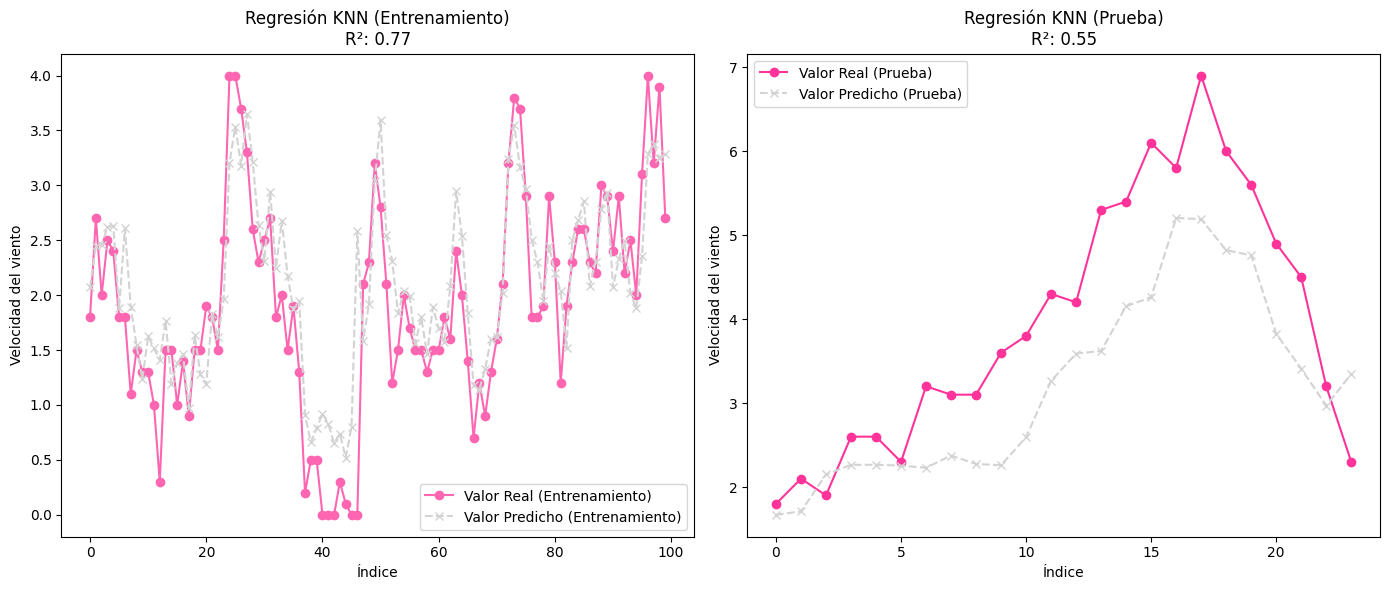

In [35]:
n_display = 100
plt.figure(figsize=(14, 6))

ypredtrainknn = knn.predict(X_train)
rmsetrainknn = mean_squared_error(y_train, ypredtrainknn, squared=False)
mapetrainknn = MAPE(y_train, ypredtrainknn)
r2trainknn = r2_score(y_train, ypredtrainknn)

# Gráfico para el conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(n_display), y_train[:n_display], label="Valor Real (Entrenamiento)", color='#FF66B2', linestyle='-', marker='o')
plt.plot(range(n_display), ypredtrainknn[:n_display], label="Valor Predicho (Entrenamiento)", color='#D3D3D3', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Regresión KNN (Entrenamiento)\nR²: {r2trainknn:.2f}")
plt.legend()

# Gráfico para el conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test)), y_test, label="Valor Real (Prueba)", color='#FF3399', linestyle='-', marker='o')
plt.plot(range(len(ypredknn)), ypredknn, label="Valor Predicho (Prueba)", color='#D3D3D3', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Regresión KNN (Prueba)\nR²: {r2knn:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

El rendimiento del modelo KNN disminuyó significativamente en el conjunto de prueba, pasando de un `R²`de `0.77` en entrenamiento a `0.55` en prueba, lo que indica que no logró generalizar bien datos desconocidos. Las líneas de valores predichos no logran capturar adecuadamente los picos, mostrando sensibilidad limitada a valores extremos. Aunque, en la gráfica relacionada con test, en la prueba la línea predicha sigue un patrón similar al de los valores reales, no se acerca lo suficiente, lo que evidencia que KNN no logró ajustarse correctamente a los datos.

In [64]:
import pickle
with open("C:/Users/valcd/OneDrive/Escritorio/MachinelearningUN/modeloknn.pkl", 'wb') as f:
    pickle.dump(knn, f)
    pickle.dump(y_train, f)
    pickle.dump(ypredtrainknn, f)
    pickle.dump(y_test, f)
    pickle.dump(ypredknn, f)
    pickle.dump(cuadro1, f)

## **Ridge**

Para este modelo, los hiperparámetros utilizados fueron:

* **`alpha`** : controla la fuerza de la regularización. 

* **`solver`** : especifica el algoritmo utilizado para optimizar la solución de Ridge.

    * **auto**
    * **svd**
    * **cholesky**
    * **lsqr**
    * **saga**

    

In [11]:
r2_val = []
best_r2 = -float('inf')  
best_alpha = None
best_solver = None

for alpha in np.linspace(0.01, 10.0, 100):  
    for solver in ["auto", "svd", "cholesky", "lsqr", "saga"]:
        ridge = Ridge(alpha=alpha, solver=solver)
        ridge.fit(X_train, y_train)

        y_pred = ridge.predict(X_val)

        r2 = r2_score(y_val, y_pred)  

        if r2 > best_r2:  
            best_r2 = r2
            best_alpha = alpha
            best_solver = solver

        r2_val.append((alpha, solver, r2))

print(f"Best R²: {best_r2}, Best alpha: {best_alpha}, Best solver: {best_solver}")


Best R²: 0.6346833364178861, Best alpha: 2.129090909090909, Best solver: saga


Luego de entrenar el modelo con los datos de entrenamiento y realizar predicciones en el conjunto de validación, se evaluaron las combinaciones de hiperparámetros. La mejor de estas, que alcanzó el mayor valor de R² entre todos, fue `alpha = 2.129090909090909` y `solver = saga`, con un `R² de 0.6346`.

In [6]:
ridge = Ridge(alpha = 2.129090909090909, solver = 'saga')

ridge.fit(X_train,y_train)
ypredridge = ridge.predict(X_test)
ridge.score(X_test, y_test)

0.8377410519527606

In [51]:
mseridge = mean_squared_error(y_test, ypredridge)
rmseridge = np.sqrt(mseridge)
maperidge = MAPE(y_test, ypredridge)
maeridge = mean_absolute_error(y_test, ypredridge)
r2ridge = r2_score(y_test, ypredridge)
ljungboxridge, jarqueberaridge, residuosridge = residuos(y_test, ypredridge)

In [8]:
valoresridge = {'Modelo': ['RIDGE'],'MSE': [mseridge],'RMSE': [rmseridge],'MAPE': [maperidge],'MAE': [maeridge],'R2': [r2ridge],'Ljung-Box p-value': [ljungboxridge],'Jarque-Bera p-value': [jarqueberaridge]}
cuadro2 = pd.DataFrame(valoresridge)
cuadro2

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,RIDGE,0.358581,0.598816,15.746817,0.541537,0.837741,0.192629,0.095406


El modelo Ridge muestra un buen rendimiento general. El `RMSE` de aproximadamente `0.59` indica que, en promedio, las predicciones tienen una desviación de `0.59` unidades respecto a los valores observados, mientras que el `MAPE`, que mide el porcentaje de error en las predicciones, es del `15%`, lo cual refleja un error moderado. El coeficiente de determinación `R²` es `0.84` aproximado, lo que significa que el modelo logra explicar el `84%` de la variabilidad en los datos.

En cuanto a los residuos, el `valor p de Ljung-Box (0.192629)` sugiere que **no hay autocorrelación significativa**, lo cual es positivo. Por otro lado, el `valor p de Jarque-Bera (0.095406)` indica que los **residuos presentan distribución normal**, es decir, se cumplen los dos supuestos.



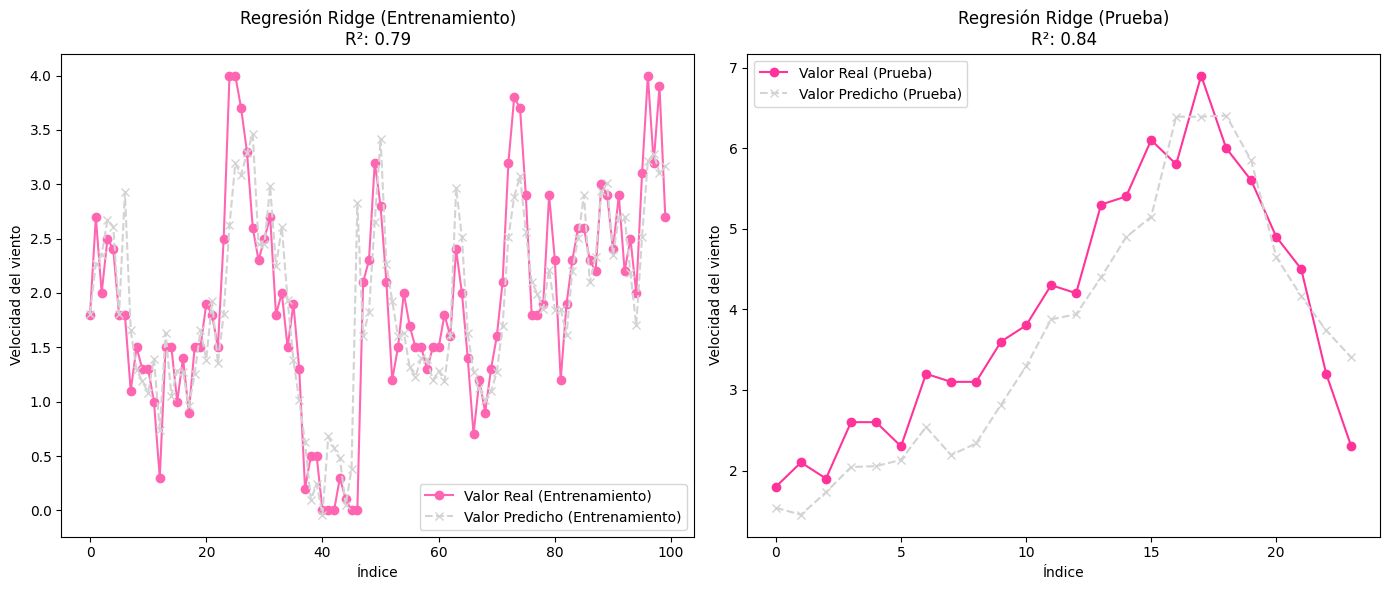

In [36]:
plt.figure(figsize=(14, 6))

ypredtrainridge = ridge.predict(X_train)
rmsetrainridge = mean_squared_error(y_train, ypredtrainridge, squared=False)
mapetrainridge = MAPE(y_train, ypredtrainridge)
r2trainridge = r2_score(y_train, ypredtrainridge)

# Gráfico para el conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(n_display), y_train[:n_display], label="Valor Real (Entrenamiento)", color='#FF66B2', linestyle='-', marker='o')
plt.plot(range(n_display), ypredtrainridge[:n_display], label="Valor Predicho (Entrenamiento)", color='#D3D3D3', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Regresión Ridge (Entrenamiento)\nR²: {r2trainridge:.2f}")
plt.legend()

# Gráfico para el conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test)), y_test, label="Valor Real (Prueba)", color='#FF3399', linestyle='-', marker='o')
plt.plot(range(len(ypredridge)), ypredridge, label="Valor Predicho (Prueba)", color='#D3D3D3', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Regresión Ridge (Prueba)\nR²: {r2ridge:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

En el modelo Ridge, el conjunto de prueba muestra un mejor rendimiento que el de entrenamiento, ya que el `R²` incrementó de **0.79** a **0.84**. Esto indica que el modelo logra generalizar bien los datos no vistos. Sin embargo, las líneas de valores predichos no logran capturar adecuadamente los picos en ambas gráficas, evidenciando una sensibilidad limitada a valores extremos. A pesar de ello, en la gráfica correspondiente al conjunto de prueba, la línea de valores predichos sigue un patrón similar al de los valores reales, aunque con desviaciones notables. 


In [65]:
import pickle
with open("C:/Users/valcd/OneDrive/Escritorio/MachinelearningUN/modeloridge.pkl", 'wb') as f:
    pickle.dump(ridge, f)
    pickle.dump(y_train, f)
    pickle.dump(ypredtrainridge, f)
    pickle.dump(y_test, f)
    pickle.dump(ypredridge, f)
    pickle.dump(cuadro2, f)

## **Lasso**

Para este modelo, los hiperparámetros utilizados fueron:

* **`alpha`** : controla la fuerza de la regularización.

* **`max_iter`** : número máximo de iteraciones que el algoritmo realizará para converger a una solución óptima.

* **`tol`** : tolerancia para el criterio de convergencia. 

In [ ]:
r2_val = []
best_r2 = -float('inf')  
best_alpha = None
best_max_iter = None
best_tol = None

for alpha in np.linspace(0.01, 10.0, 100):  
    for max_iter in range(1000, 2001, 500):  
        for tol in np.linspace(1e-4, 1e-3, 5):
            lasso = Lasso(alpha=alpha, max_iter=max_iter, tol=tol)
            lasso.fit(X_train, y_train)

            y_pred = lasso.predict(X_val)

            r2 = r2_score(y_val, y_pred)  

            if r2 > best_r2:  
                best_r2 = r2
                best_alpha = alpha
                best_max_iter = max_iter
                best_tol = tol

            r2_val.append((alpha, max_iter, tol, r2))

print(f"Best R²: {best_r2}")
print(f"Best alpha: {best_alpha}, Best max_iter: {best_max_iter}, Best tol: {best_tol}")


Best R²: 0.7355674278906983
Best alpha: 0.41363636363636364, Best max_iter: 1000, Best tol: 0.0001


Luego de entrenar el modelo con los datos de entrenamiento y realizar predicciones en el conjunto de validación, se evaluaron las combinaciones de hiperparámetros. La mejor de estas, que alcanzó el mayor valor de R² entre todos, fue `alpha = 0.41363636363636364`, `max_iter = 1000` y `tol = 0.0001`, con un `R² de 0.7355`.

In [12]:
lasso = Lasso(alpha = 0.41363636363636364, max_iter= 1000,tol= 0.0001 )

lasso.fit(X_train,y_train)
ypredlasso = lasso.predict(X_test)
lasso.score(X_test, y_test)

0.788059043088072

In [13]:
mselasso = mean_squared_error(y_test, ypredlasso)
rmselasso = np.sqrt(mselasso)
mapelasso = MAPE(y_test, ypredlasso)
maelasso = mean_absolute_error(y_test, ypredlasso)
r2lasso = r2_score(y_test, ypredlasso)
ljungboxlasso, jarqueberalasso = residuos(y_test, ypredlasso)

In [14]:
valoreslasso = {'Modelo': ['LASSO'],'MSE': [mselasso],'RMSE': [rmselasso],'MAPE': [mapelasso],'MAE': [maelasso],'R2': [r2lasso],'Ljung-Box p-value': [ljungboxlasso],'Jarque-Bera p-value': [jarqueberalasso]}
cuadro3 = pd.DataFrame(valoreslasso)
cuadro3

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,LASSO,0.468375,0.684379,15.627265,0.586556,0.788059,0.284742,0.050258


Sobre el modelo Lasso, podemos ver que muestra un buen rendimiento general. El `RMSE` de aproximadamente `0.68` indica que, en promedio, las predicciones tienen una desviación de `0.68` unidades respecto a los valores observados, mientras que el `MAPE`, que mide el porcentaje de error en las predicciones, es del `15%`, lo cual refleja un error moderado. El coeficiente de determinación `R²` es `0.79` aproximado, lo que significa que el modelo logra explicar el `79%` de la variabilidad en los datos.

En cuanto a los residuos, el `valor p de Ljung-Box (0.284742)` sugiere que **no hay autocorrelación significativa**, lo cual es positivo. Por otro lado, el `valor p de Jarque-Bera (0.050258)` indica que los **residuos presentan distribución normal**, es decir, se cumplen los dos supuestos.

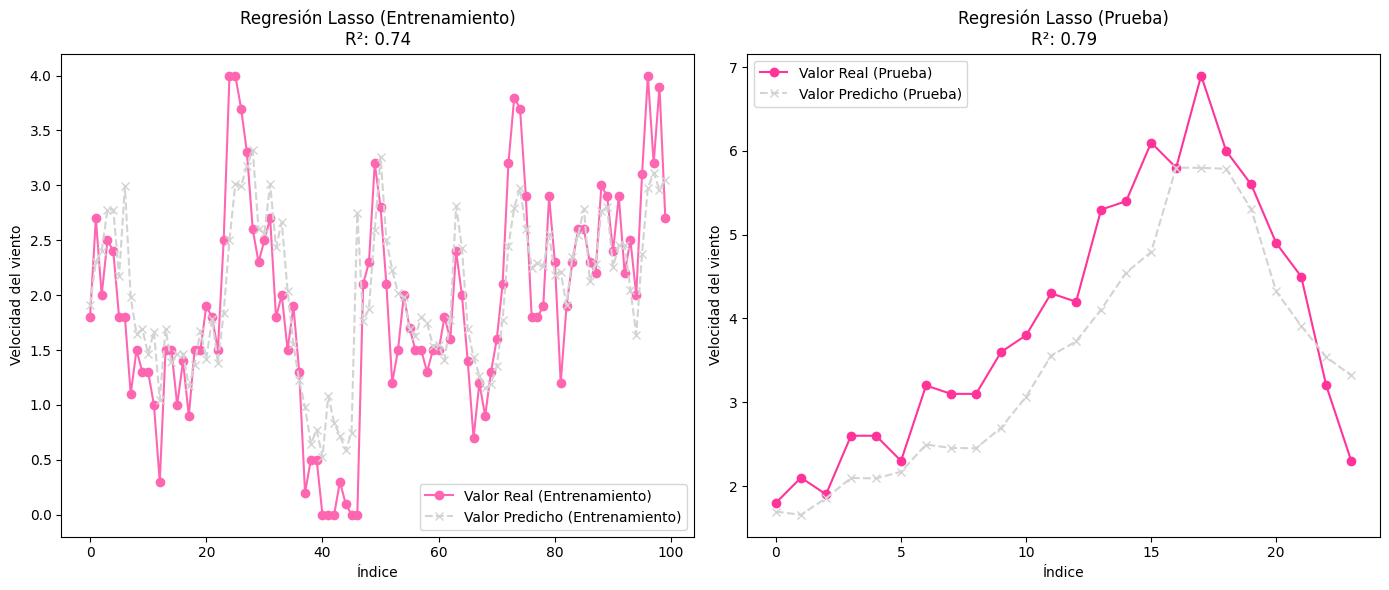

In [37]:
plt.figure(figsize=(14, 6))

ypredtrainlasso = lasso.predict(X_train)
rmsetrainlasso = mean_squared_error(y_train, ypredtrainlasso, squared=False)
mapetrainlasso = MAPE(y_train, ypredtrainlasso)
r2trainlasso = r2_score(y_train, ypredtrainlasso)

# Gráfico para el conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(n_display), y_train[:n_display], label="Valor Real (Entrenamiento)", color='#FF66B2', linestyle='-', marker='o')
plt.plot(range(n_display), ypredtrainlasso[:n_display], label="Valor Predicho (Entrenamiento)", color='#D3D3D3', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Regresión Lasso (Entrenamiento)\nR²: {r2trainlasso:.2f}")
plt.legend()

# Gráfico para el conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test)), y_test, label="Valor Real (Prueba)", color='#FF3399', linestyle='-', marker='o')
plt.plot(range(len(ypredlasso)), ypredlasso, label="Valor Predicho (Prueba)", color='#D3D3D3', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Regresión Lasso (Prueba)\nR²: {r2lasso:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

En el modelo Lasso, el conjunto de prueba muestra un mejor rendimiento que el de entrenamiento, ya que el `R²` incrementó de `0.74` a `0.79`. Esto indica que el modelo tiene una capacidad aceptable para generalizar los datos no vistos. Sin embargo, las líneas de valores predichos no logran capturar adecuadamente los picos en ambas gráficas, reflejando una sensibilidad limitada a valores extremos. A pesar de esto, en la gráfica correspondiente al conjunto de prueba, la línea de valores predichos sigue un patrón similar al de los valores reales, aunque con desviaciones que demuestran un ajuste imperfecto.

In [66]:
import pickle
with open("C:/Users/valcd/OneDrive/Escritorio/MachinelearningUN/modelolasso.pkl", 'wb') as f:
    pickle.dump(lasso, f)
    pickle.dump(y_train, f)
    pickle.dump(ypredtrainlasso, f)
    pickle.dump(y_test, f)
    pickle.dump(ypredlasso, f)
    pickle.dump(cuadro3, f)

## **Decision Tree**

Para este modelo, los hiperparámetros utilizados fueron:

* **`max_depth`** : profundidad máxima del árbol de decisión.

* **`min_samples_split`** : número mínimo de muestras requeridas para dividir un nodo.

In [ ]:
r2_val = []
best_r2 = -float('inf')  
best_max_depth = None
best_min_samples_split = None
best_min_samples_leaf = None

for max_depth in range(10, 50):  
    for min_samples_split in range(2, 21):   
           
            tree = DecisionTreeRegressor(
                max_depth=max_depth,
                min_samples_split=min_samples_split
            )
            tree.fit(X_train, y_train)
            y_pred = tree.predict(X_val)

            r2 = r2_score(y_val, y_pred)

            if r2 > best_r2:  
                best_r2 = r2
                best_max_depth = max_depth
                best_min_samples_split = min_samples_split
        

            r2_val.append((max_depth, min_samples_split, r2))

print(f"Best R²: {best_r2}")
print(f"Best max_depth: {best_max_depth}, Best min_samples_split: {best_min_samples_split}")


Best R²: 0.44002042864896185
Best max_depth: 10, Best min_samples_split: 15


Luego de entrenar el modelo con los datos de entrenamiento y realizar predicciones en el conjunto de validación, se evaluaron las combinaciones de hiperparámetros. La mejor de estas, que alcanzó el mayor valor de R² entre todos, fue `max_depth = 10` y `min_samples_split = 15`, con un `R² de 0.44`.

In [15]:
dectree = DecisionTreeRegressor(max_depth= 10, min_samples_leaf= 15 )

dectree.fit(X_train,y_train)
ypreddectree = dectree.predict(X_test)
dectree.score(X_test, y_test)

0.728265730091423

In [16]:
msedectree = mean_squared_error(y_test, ypreddectree)
rmsedectree = np.sqrt(msedectree)
mapedectree = MAPE(y_test, ypreddectree)
maedectree = mean_absolute_error(y_test, ypreddectree)
r2dectree = r2_score(y_test, ypreddectree)
ljungboxdectree, jarqueberadectree = residuos(y_test, ypreddectree)

In [17]:
valoresdectree = {'Modelo': ['DEC. TREE'],'MSE': [msedectree],'RMSE': [rmsedectree],'MAPE': [mapedectree],'MAE': [maedectree],'R2': [r2dectree],'Ljung-Box p-value': [ljungboxdectree],'Jarque-Bera p-value': [jarqueberadectree]}
cuadro4 = pd.DataFrame(valoresdectree)
cuadro4

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,DEC. TREE,0.600514,0.774928,17.311127,0.61918,0.728266,0.692234,0.204984


A partir de la tabla, podemos ver que el modelo de árboles de decisión muestra un rendimiento moderado. El `RMSE` de aproximadamente `0.77` indica que, en promedio, las predicciones tienen una desviación de `0.77` unidades respecto a los valores observados, mientras que el `MAPE`, que mide el porcentaje de error en las predicciones, es del `17%`, lo cual refleja un error moderado. El coeficiente de determinación `R²` es `0.73` aproximado, lo que significa que el modelo logra explicar el `73%` de la variabilidad en los datos.

En cuanto a los residuos, el `valor p de Ljung-Box (0.692234)` sugiere que **no hay autocorrelación significativa**, lo cual es positivo. Por otro lado, el `valor p de Jarque-Bera (0.204984)` indica que los **residuos presentan distribución normal**, es decir, se cumplen los dos supuestos.

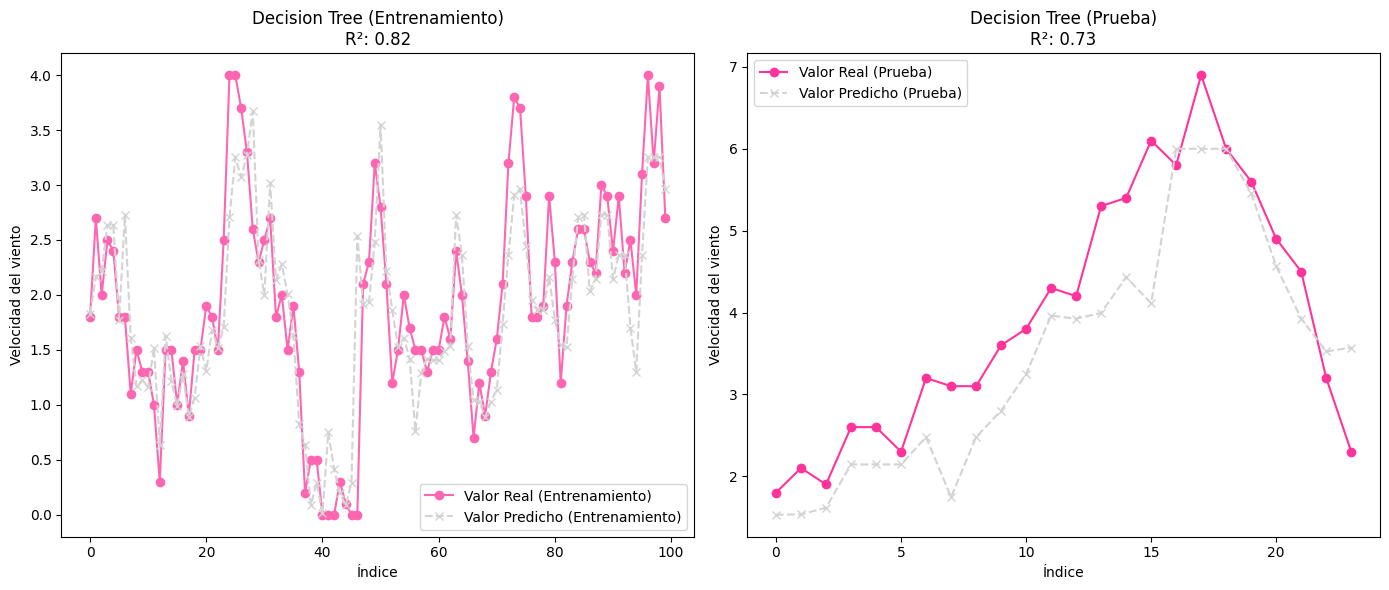

In [38]:
plt.figure(figsize=(14, 6))

ypredtraindectree = dectree.predict(X_train)
rmsetraindectree = mean_squared_error(y_train, ypredtraindectree, squared=False)
mapetraindectree = MAPE(y_train, ypredtraindectree)
r2traindectree = r2_score(y_train, ypredtraindectree)

# Gráfico para el conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(n_display), y_train[:n_display], label="Valor Real (Entrenamiento)", color='#FF66B2', linestyle='-', marker='o')
plt.plot(range(n_display), ypredtraindectree[:n_display], label="Valor Predicho (Entrenamiento)", color='#D3D3D3', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Decision Tree (Entrenamiento)\nR²: {r2traindectree:.2f}")
plt.legend()

# Gráfico para el conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test)), y_test, label="Valor Real (Prueba)", color='#FF3399', linestyle='-', marker='o')
plt.plot(range(len(ypreddectree)), ypreddectree, label="Valor Predicho (Prueba)", color='#D3D3D3', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Decision Tree (Prueba)\nR²: {r2dectree:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

El rendimiento del modelo disminuyó notablemente en el conjunto de prueba, pasando de un `coeficiente de determinación (R²)` de `0.82` en el entrenamiento a `0.73` en el de prueba. Esto indica que el modelo tiene dificultades para generalizar a datos desconocidos. Aunque las líneas de valores predichos en la gráfica correspondiente a entrenamiento logran capturar algunos picos, su sensibilidad a valores extremos es limitada. En la gráfica del conjunto de prueba, se observa que la línea de predicciones sigue un patrón similar al de los valores reales, pero no logra aproximarse con la precisión necesaria. Esto evidencia que el modelo basado en árboles de decisión no se ajusta de manera adecuada a los datos y presenta deficiencias en su capacidad predictiva.

In [67]:
import pickle
with open("C:/Users/valcd/OneDrive/Escritorio/MachinelearningUN/modelodectree.pkl", 'wb') as f:
    pickle.dump(dectree, f)
    pickle.dump(y_train, f)
    pickle.dump(ypredtraindectree, f)
    pickle.dump(y_test, f)
    pickle.dump(ypreddectree, f)
    pickle.dump(cuadro4, f)

## **Random Forest**

Para este modelo, los hiperparámetros utilizados fueron:

- **`n_estimators`**: número de árboles en el bosque.

- **`max_depth`**: profundidad máxima de cada árbol en el bosque.

In [ ]:
r2_val = []
best_r2 = -float('inf')  
best_n_estimators = None
best_max_depth = None

for n_estimators in range(10, 51, 10):  
    for max_depth in range(5, 11):  

        rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
        rf.fit(X_train, y_train)  

        y_pred = rf.predict(X_val)  

        r2 = r2_score(y_val, y_pred)  

        if r2 > best_r2:  
            best_r2 = r2
            best_n_estimators = n_estimators
            best_max_depth = max_depth

        r2_val.append((n_estimators, max_depth, r2))

print(f"Best R²: {best_r2}")
print(f"Best n_estimators: {best_n_estimators}, Best max_depth: {best_max_depth}")


Best R²: 0.6962951827501135
Best n_estimators: 10, Best max_depth: 7


Luego de entrenar el modelo con los datos de entrenamiento y realizar predicciones en el conjunto de validación, se evaluaron las combinaciones de hiperparámetros. La mejor de estas, que alcanzó el mayor valor de R² entre todos, fue `n_estimators = 10` y `max_depth = 7`, con un `R² de 0.6962`.

In [18]:
ranfor = RandomForestRegressor(n_estimators= 10,max_depth= 7)

ranfor.fit(X_train,y_train)
ypredranfor = ranfor.predict(X_test)
ranfor.score(X_test, y_test)

0.7660328676169351

In [19]:
mseranfor = mean_squared_error(y_test, ypredranfor)
rmseranfor = np.sqrt(mseranfor)
maperanfor = MAPE(y_test, ypredranfor)
maeranfor = mean_absolute_error(y_test, ypredranfor)
r2ranfor = r2_score(y_test, ypredranfor)
ljungboxranfor, jarquebreranfor = residuos(y_test, ypredranfor)

In [20]:
valoresranfor = {'Modelo': ['RANDOM FOREST'],'MSE': [mseranfor],'RMSE': [rmseranfor],'MAPE': [maperanfor],'MAE': [maeranfor],'R2': [r2ranfor],'Ljung-Box p-value': [ljungboxranfor],'Jarque-Bera p-value': [jarquebreranfor]}
cuadro5 = pd.DataFrame(valoresranfor)
cuadro5

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,RANDOM FOREST,0.517051,0.719063,16.628608,0.621354,0.766033,0.34443,0.697858


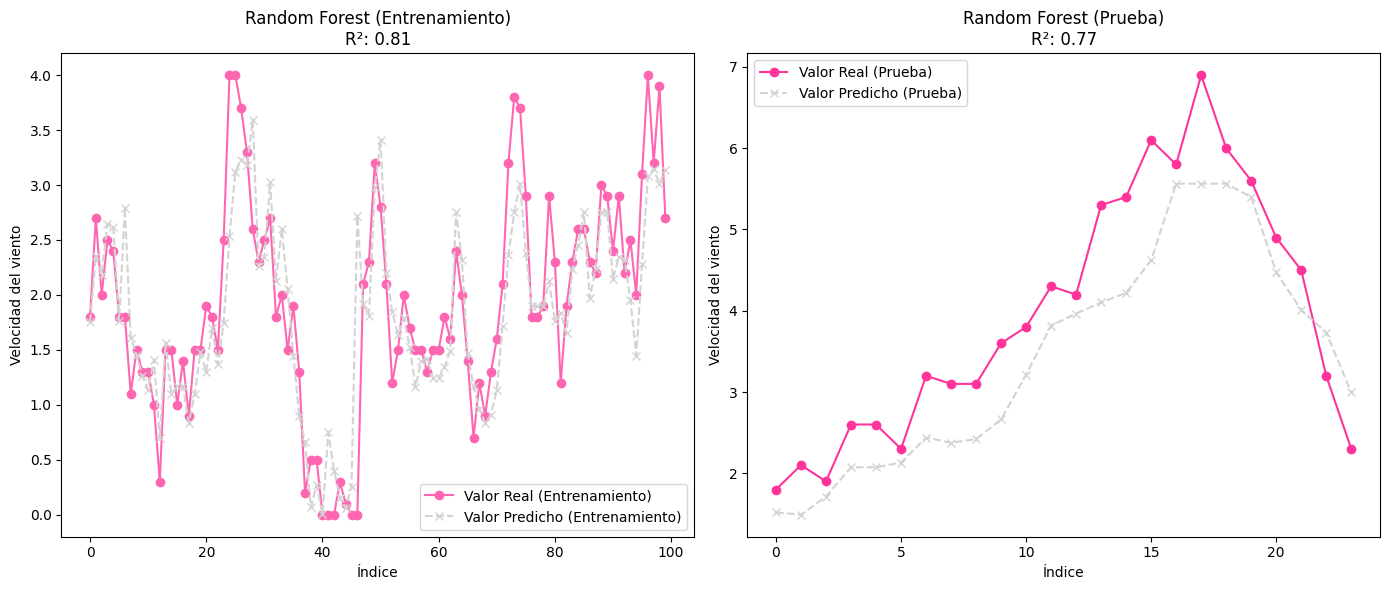

In [39]:
plt.figure(figsize=(14, 6))

ypredtrainranfor = ranfor.predict(X_train)
rmsetrainranfor = mean_squared_error(y_train, ypredtrainranfor, squared=False)
mapetrainranfor = MAPE(y_train, ypredtrainranfor)
r2trainranfor = r2_score(y_train, ypredtrainranfor)

# Gráfico para el conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(n_display), y_train[:n_display], label="Valor Real (Entrenamiento)", color='#FF66B2', linestyle='-', marker='o')
plt.plot(range(n_display), ypredtrainranfor[:n_display], label="Valor Predicho (Entrenamiento)", color='#D3D3D3', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Random Forest (Entrenamiento)\nR²: {r2trainranfor:.2f}")
plt.legend()

# Gráfico para el conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test)), y_test, label="Valor Real (Prueba)", color='#FF3399', linestyle='-', marker='o')
plt.plot(range(len(ypredranfor)), ypredranfor, label="Valor Predicho (Prueba)", color='#D3D3D3', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Random Forest (Prueba)\nR²: {r2ranfor:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

In [73]:
import pickle
with open("C:/Users/valcd/OneDrive/Escritorio/MachinelearningUN/modeloranfor.pkl", 'wb') as f:
    pickle.dump(ranfor, f)
    pickle.dump(y_train, f)
    pickle.dump(ypredtrainranfor, f)
    pickle.dump(y_test, f)
    pickle.dump(ypredranfor, f)
    pickle.dump(cuadro5, f)

## **XGBoost**

In [59]:
r2_val = []
best_r2 = -float('inf')  
best_n_estimators = None
best_max_depth = None
best_learning_rate = None

# Rango de búsqueda
for n_estimators in range(10, 101, 10):  # Entre 10 y 100 estimadores, en pasos de 10
    for max_depth in range(5, 21):  # Entre 5 y 20 para la profundidad máxima
            
            # Definir el modelo XGBoost
            xgb = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth)
            
            # Entrenar el modelo
            xgb.fit(X_train, y_train)

            # Realizar predicciones
            y_pred = xgb.predict(X_val)

            # Calcular el R² en el conjunto de validación
            r2 = r2_score(y_val, y_pred)

            # Si el R² es el mejor encontrado, actualizar
            if r2 > best_r2:
                best_r2 = r2
                best_n_estimators = n_estimators
                best_max_depth = max_depth

            # Almacenar los resultados
            r2_val.append((n_estimators, max_depth, r2))

# Resultados finales
print(f"Best R²: {best_r2}")
print(f"Best n_estimators: {best_n_estimators}, Best max_depth: {best_max_depth}")


Best R²: 0.6859964789599433
Best n_estimators: 10, Best max_depth: 6


In [29]:
xgboost = XGBRegressor(n_estimators= 10,max_depth= 6)

xgboost.fit(X_train,y_train)
ypredxgboost = xgboost.predict(X_test)
xgboost.score(X_test, y_test)

0.7868021781963137

In [30]:
msexgboost = mean_squared_error(y_test, ypredxgboost)
rmsexgboost = np.sqrt(msexgboost)
mapexgboost = MAPE(y_test, ypredxgboost)
maexgboost = mean_absolute_error(y_test, ypredxgboost)
r2xgboost = r2_score(y_test, ypredxgboost)
ljungboxxgboost, jarquebarexgboost = residuos(y_test, ypredxgboost)

In [31]:
valoresxgboost = {'Modelo': ['XGBOOST'],'MSE': [msexgboost],'RMSE': [rmsexgboost],'MAPE': [mapexgboost],'MAE': [maexgboost],'R2': [r2xgboost],'Ljung-Box p-value': [ljungboxxgboost],'Jarque-Bera p-value': [jarquebarexgboost]}
cuadro6 = pd.DataFrame(valoresxgboost)
cuadro6

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,XGBOOST,0.471152,0.686405,14.995415,0.572242,0.786802,0.236152,0.910029


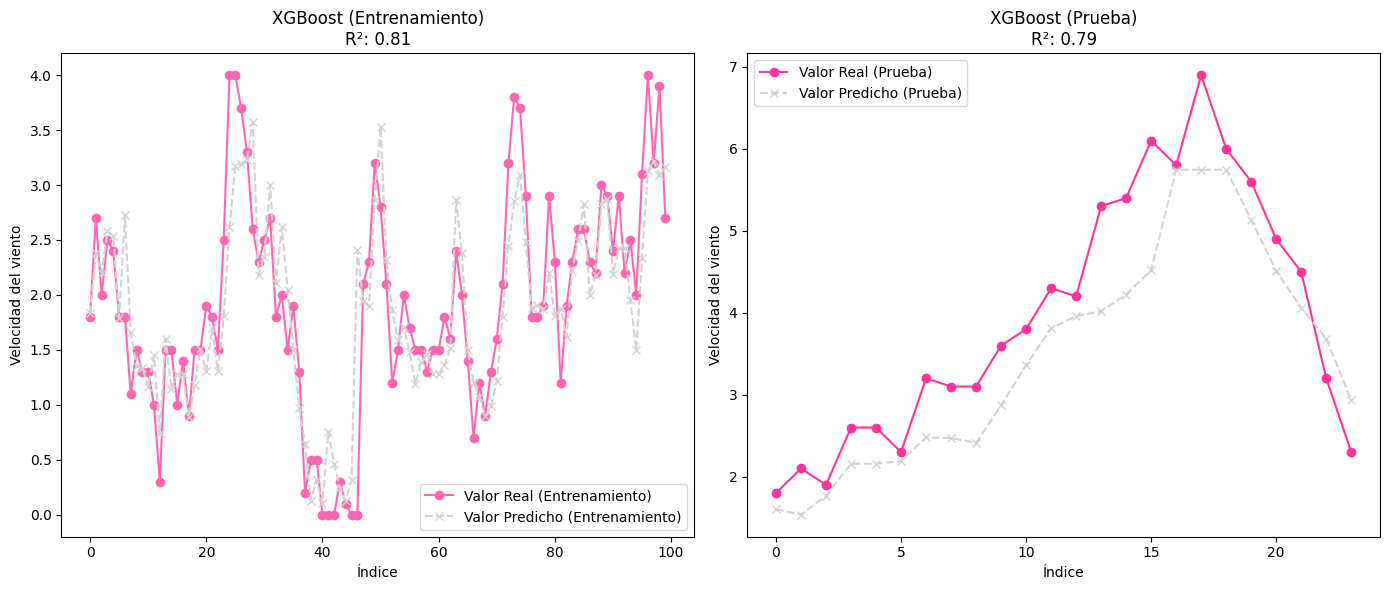

In [40]:
plt.figure(figsize=(14, 6))

ypredtrainxgboost = xgboost.predict(X_train)
rmsetrainxgboost = mean_squared_error(y_train, ypredtrainxgboost, squared=False)
mapetrainxgboost = MAPE(y_train, ypredtrainxgboost)
r2trainxgboost = r2_score(y_train, ypredtrainxgboost)

# Gráfico para el conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(n_display), y_train[:n_display], label="Valor Real (Entrenamiento)", color='#FF66B2', linestyle='-', marker='o')
plt.plot(range(n_display), ypredtrainxgboost[:n_display], label="Valor Predicho (Entrenamiento)", color='#D3D3D3', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"XGBoost (Entrenamiento)\nR²: {r2trainxgboost:.2f}")
plt.legend()

# Gráfico para el conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test)), y_test, label="Valor Real (Prueba)", color='#FF3399', linestyle='-', marker='o')
plt.plot(range(len(ypredxgboost)), ypredxgboost, label="Valor Predicho (Prueba)", color='#D3D3D3', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"XGBoost (Prueba)\nR²: {r2xgboost:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

In [75]:
import pickle
with open("C:/Users/valcd/OneDrive/Escritorio/MachinelearningUN/xgboostdata.pkl", 'wb') as f:
    pickle.dump(xgboost, f)
    pickle.dump(y_train, f)
    pickle.dump(ypredtrainxgboost, f)
    pickle.dump(y_test, f)
    pickle.dump(ypredxgboost, f)
    pickle.dump(cuadro6, f)

## **SVR**

In [6]:
r2_val = []
best_r2 = -float('inf')
best_C = None
best_kernel = None
best_gamma = None

for C in np.arange(0.1, 1, 0.1):  
    for kernel in ["linear"]:  
        for gamma in ["scale", "auto"]:  

            svr = SVR(C=C, kernel=kernel, gamma=gamma)

            svr.fit(X_train, y_train)

            y_pred = svr.predict(X_val)

            r2 = r2_score(y_val, y_pred)

            if r2 > best_r2:
                best_r2 = r2
                best_C = C
                best_kernel = kernel
                best_gamma = gamma

            r2_val.append((C, kernel, gamma, r2))

print(f"Best R²: {best_r2}")
print(f"Best C: {best_C}, Best kernel: {best_kernel}, Best gamma: {best_gamma}")

Best R²: 0.6045617399345776
Best C: 0.1, Best kernel: linear, Best gamma: scale


In [24]:
svr = SVR(C=0.1, kernel='linear', gamma='scale')

svr.fit(X_train,y_train)
ypredsvr = svr.predict(X_test)
svr.score(X_test, y_test)

0.835982742196057

In [25]:
msesvr = mean_squared_error(y_test, ypredsvr)
rmsesvr = np.sqrt(msesvr)
mapesvr = MAPE(y_test,ypredsvr)
maesvr = mean_absolute_error(y_test, ypredsvr)
r2svr = r2_score(y_test, ypredsvr)
ljungboxsvr, jarquebaresvr = residuos(y_test, ypredsvr) 

In [26]:
valoressvr = {'Modelo': ['SVR'],'MSE': [msesvr],'RMSE': [rmsesvr],'MAPE': [mapesvr],'MAE': [maesvr],'R2': [r2svr],'Ljung-Box p-value': [ljungboxsvr],'Jarque-Bera p-value': [jarquebaresvr]}
cuadro7 = pd.DataFrame(valoressvr)
cuadro7

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,SVR,0.362467,0.602052,15.125073,0.508772,0.835983,0.015236,0.14863


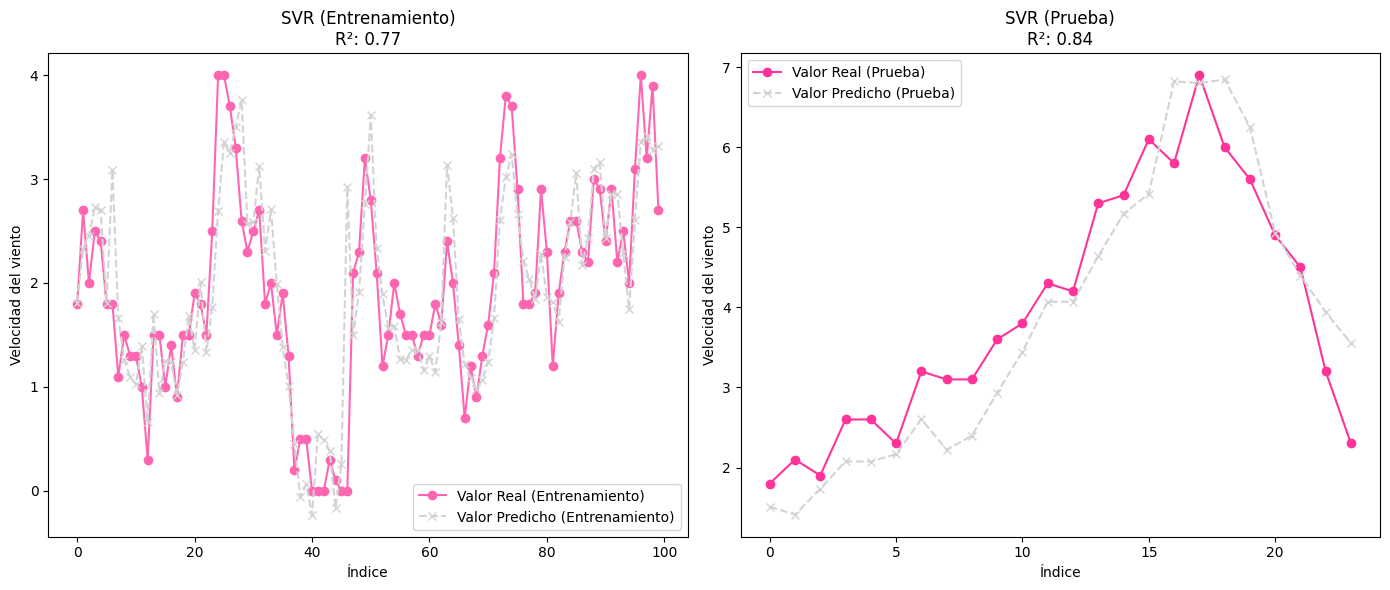

In [28]:
n_display = 100
plt.figure(figsize=(14, 6))

ypredtrainsvr = svr.predict(X_train)
rmsetrainsvr = mean_squared_error(y_train, ypredtrainsvr, squared=False)
mapetrainsvr = MAPE(y_train, ypredtrainsvr)
r2trainsvr = r2_score(y_train, ypredtrainsvr)

plt.subplot(1, 2, 1)
plt.plot(range(n_display), y_train[:n_display], label="Valor Real (Entrenamiento)", color='#FF66B2', linestyle='-', marker='o')
plt.plot(range(n_display), ypredtrainsvr[:n_display], label="Valor Predicho (Entrenamiento)", color='#D3D3D3', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"SVR (Entrenamiento)\nR²: {r2trainsvr:.2f}")
plt.legend()

# Gráfico para el conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test)), y_test, label="Valor Real (Prueba)", color='#FF3399', linestyle='-', marker='o')
plt.plot(range(len(ypredsvr)), ypredsvr, label="Valor Predicho (Prueba)", color='#D3D3D3', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"SVR (Prueba)\nR²: {r2svr:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

In [12]:
import pickle
with open("C:/Users/valcd/OneDrive/Escritorio/MachinelearningUN/svrdata.pkl", 'wb') as f:
    pickle.dump(svr, f)
    pickle.dump(y_train, f)
    pickle.dump(ypredtrainsvr, f)
    pickle.dump(y_test, f)
    pickle.dump(ypredsvr, f)
    pickle.dump(cuadro7, f)

## **REGRESIÓN LINEAL**

In [41]:
reglin = LinearRegression()

reglin.fit(X_train, y_train)

ypredreglin = reglin.predict(X_test)

In [42]:
msereglin = mean_squared_error(y_test, ypredreglin)
rmsereglin = np.sqrt(msereglin)
mapereglin =MAPE(y_test,ypredreglin)
maereglin = mean_absolute_error(y_test, ypredreglin)
r2reglin = r2_score(y_test, ypredreglin)
ljungboxreglin, jarqueberareglin = residuos(y_test, ypredreglin) 

In [43]:
valoresreglin = {'Modelo': ['REG. LINEAL'],'MSE': [msereglin],'RMSE': [rmsereglin],'MAPE': [mapereglin],'MAE': [maereglin],'R2': [r2reglin],'Ljung-Box p-value': [ljungboxreglin],'Jarque-Bera p-value': [jarqueberareglin]}
cuadro8 = pd.DataFrame(valoresreglin)
cuadro8

,Modelo,MSE,RMSE,MAPE,MAE,R2,Ljung-Box p-value,Jarque-Bera p-value
0,REG. LINEAL,0.358341,0.598616,15.739528,0.54131,0.83785,0.192736,0.095363


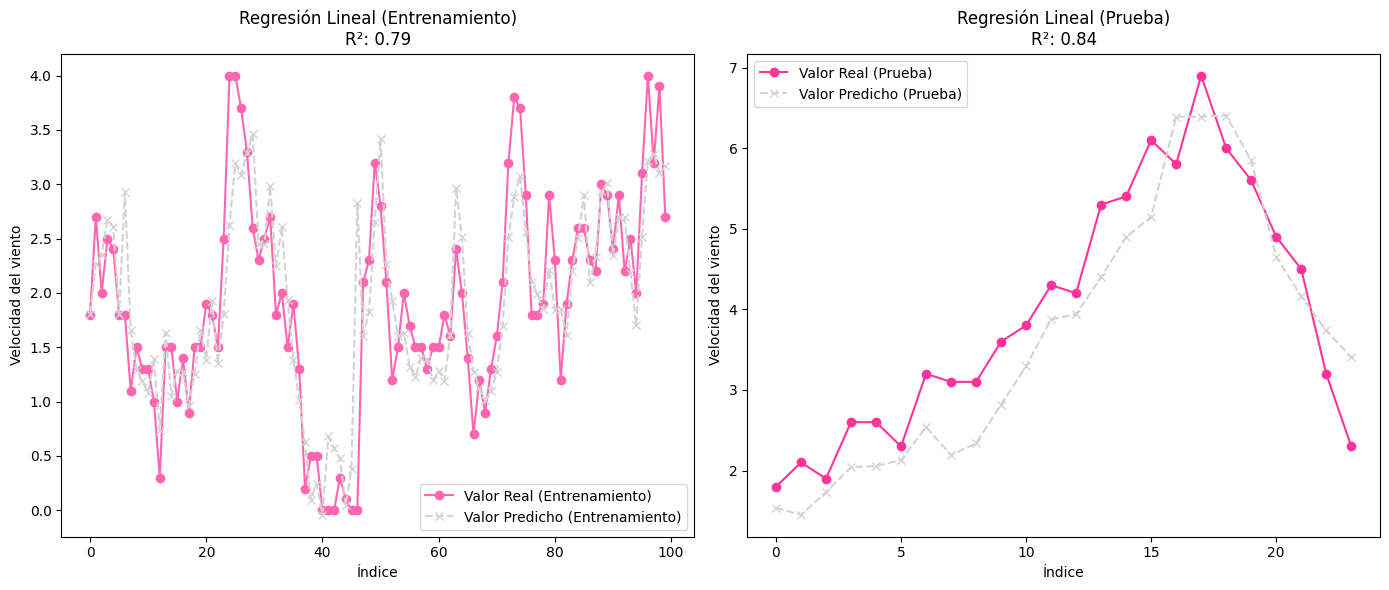

In [44]:
plt.figure(figsize=(14, 6))

ypredtrainreglin = reglin.predict(X_train)
rmsetrainreglin = mean_squared_error(y_train, ypredtrainreglin, squared=False)
mapetrainreglin = MAPE(y_train, ypredtrainreglin)
r2trainreglin = r2_score(y_train, ypredtrainreglin)

# Gráfico para el conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(n_display), y_train[:n_display], label="Valor Real (Entrenamiento)", color='#FF66B2', linestyle='-', marker='o')
plt.plot(range(n_display), ypredtrainreglin[:n_display], label="Valor Predicho (Entrenamiento)", color='#D3D3D3', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Regresión Lineal (Entrenamiento)\nR²: {r2trainreglin:.2f}")
plt.legend()

# Gráfico para el conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test)), y_test, label="Valor Real (Prueba)", color='#FF3399', linestyle='-', marker='o')
plt.plot(range(len(ypredreglin)), ypredreglin, label="Valor Predicho (Prueba)", color='#D3D3D3', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Regresión Lineal (Prueba)\nR²: {r2reglin:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

In [10]:
import pickle
with open("C:/Users/valcd/OneDrive/Escritorio/MachinelearningUN/reglindata.pkl", 'wb') as f:
    pickle.dump(reglin, f)
    pickle.dump(y_train, f)
    pickle.dump(ypredtrainreglin, f)
    pickle.dump(y_test, f)
    pickle.dump(ypredreglin, f)
    pickle.dump(cuadro8, f)